# TP1 - Cálculo de distancias

> Integrantes:

- Aleo, Rodrigo
- Bustillo, Mario
- Luna, Juan Ignacio
- Tassara, Renzo

> Objetivo:

El objetivo es poder hacer un diccionario que almacene la distancia entre 2 puntos del almacén. Esta distancia se calcula con A*. En recocido simulado y algoritmo genético, hay que aplicar demasiadas veces A* para el mismo conjunto de nodos. Por lo tanto, el objetivo es ganar tiempo ya que el resultado quedará almacenado y no será necesario volver a calcularlo.

### Variables globales

In [2]:
L_VENTANA = 540

ROJO = (255, 0, 0)
VERDE = (0, 255, 0)
AZUL = (0, 255, 0)
AMARILLO = (255, 255, 0)
BLANCO = (255, 255, 255)
NEGRO = (0, 0, 0)
VIOLETA = (128, 0, 128)
NARANJA = (255, 165 ,0)
GRIS = (128, 128, 128)
TURQUESA = (64, 224, 208)

FILAS = 20
COLUMNAS = 10

#La longitud de cada casilla es la división entera entre la longitud de la ventana y la cantidad de filas (o columnas, ya que es una ventana cuadrada).
ALTO_CASILLA = L_VENTANA // FILAS
ANCHO_CASILLA = L_VENTANA // COLUMNAS

INICIO = None
FINAL = None

CAMINO = [] #acá iré almacenando las casiilas que deben ser recorridas

DICCIONARIO_DISTANCIAS = {}


### Clase Nodo


In [3]:
class Nodo:

    def __init__(self, columna_casilla, fila_casilla):
        self.fila_casilla = fila_casilla
        self.columna_casilla = columna_casilla
        self.x = columna_casilla * ANCHO_CASILLA
        self.y = fila_casilla * ALTO_CASILLA
        self.color = BLANCO
        self.padre = None #El padre lo iré actualizando a medida que se vaya formando el camino
        self.numeroAlmacen = 0 #Cada casilla de almacén tenrá un numero
        self.numeroProducto = 0 #Cada cassilla del almacén tendrá un número de producto asociado

        #Estas son las puntuaciones de g (costo de camino) y puntuación f (costo total), que un principio son inf para todos los nodos
        #A medida que los vayamos analizando, los iremos disminuyendo
        self.f = float('inf')
        self.g = float('inf')
    
    def calcular_heuristica(self, nodo_final):
        x1, y1 = self.obtener_posicion()
        x2, y2 = nodo_final.obtener_posicion()
        self.heuristica = abs(x2-x1) + abs(y2-y1)

    def actualizar_f(self):
        self.f = self.g + self.heuristica

    def reiniciar_g_f_padre(self): #Para poder volver a correr el algoritmo en un mismo tablero
        self.g = float('inf')
        self.f = float('inf')
        self.padre = None

    def obtener_posicion(self):
        return self.columna_casilla, self.fila_casilla
    
    def resetear(self):
        self.color = BLANCO

    def hacer_inicio(self):
        self.color = NARANJA
    
    def hacer_objetivo_almacen(self):
        self.color = TURQUESA
    
    def hacer_final(self):
        self.color = AZUL
    
    def hacer_abierta(self):
        self.color = VERDE

    def hacer_cerrada(self):
        self.color = ROJO

    def hacer_obstaculo(self):
        self.color = NEGRO

    def hacer_solucion(self):
        self.color = VIOLETA

    def es_inicio(self):
        return self.color == NARANJA
    
    def es_objetivo_almacen(self):
        return self.color == TURQUESA
    
    def es_final(self):
        return self.color == AZUL
    
    def es_cerrada(self):
        return self.color == ROJO

    def es_abierta(self):
        return self.color == VERDE

    def es_obstaculo(self):
        return self.color == NEGRO

    def pintar_casilla(self):
        pygame.draw.rect(VENTANA,self.color,(self.x, self.y, ANCHO_CASILLA, ALTO_CASILLA))

    def actualizar_vecinos(self,matriz):
        
        self.vecinos = []
        
        #NOTAR QUE PRIMERO MIRO A LOS COSTADOS. A LOS ALMACENES SIEMPRE PUEDO ACCEDER POR ALGUNO DE LOS DOS COSTADOS. POR LO TANTO TOMANDO EL PRIMER ELEMENTO DEL ATRIBUTO VECINOS, PUEDO ACCEDER A LA CASILLA INICIAL

        #Miro para izquierda
        if self.columna_casilla > 0 and not matriz[self.columna_casilla-1][self.fila_casilla].es_obstaculo():
            self.vecinos.append(matriz[self.columna_casilla-1][self.fila_casilla])
        
        #Miro para derecha
        if self.columna_casilla < COLUMNAS-1 and not matriz[self.columna_casilla+1][self.fila_casilla].es_obstaculo():
            self.vecinos.append(matriz[self.columna_casilla+1][self.fila_casilla])        

        #Miro para arriba
        if self.fila_casilla > 0 and not matriz[self.columna_casilla][self.fila_casilla-1].es_obstaculo() and not matriz[self.columna_casilla][self.fila_casilla-1].es_objetivo_almacen():
            self.vecinos.append(matriz[self.columna_casilla][self.fila_casilla-1])

        #Miro para abajo
        if self.fila_casilla < FILAS-1 and not matriz[self.columna_casilla][self.fila_casilla+1].es_obstaculo() and not matriz[self.columna_casilla][self.fila_casilla+1].es_objetivo_almacen():
            self.vecinos.append(matriz[self.columna_casilla][self.fila_casilla+1])
    def esEspacioEnAlmacen(self):
        return self.numeroAlmacen > 0

### Funciones lógicas

In [4]:
def crearMatrizNodos():
    matriz = []
    for i in range(COLUMNAS):
        matriz.append([])
        for j in range(FILAS):
            nodo = Nodo(i,j)
            matriz[i].append(nodo)
    return matriz

def guardarCamino(matriz, nodo_final):
    flag = True
    nodo = nodo_final
    caminoCorto = [] #Lista auxiliar donde se guardan nodos pero desde el final hasta el iniciao (como recorriendo en camino inverso)
    while flag:
        #Como el robot no entra al espacio de almacén, su última posición debe ser una casilla antes.
        if nodo.padre and nodo.padre!=INICIO:
            nodo = nodo.padre
            caminoCorto.append(nodo)
        
        #Una vez recorro toda la herencia
        else:
            for nodo in reversed(caminoCorto): #Acá guardo la lista pero esta vez bien ordenada desde el inicio al final
                CAMINO.append(nodo)
            caminoCorto = []
            flag = False

    return False
    

Tengo que asignar a las casillas del almacén un número a cada una. El resto quedarán en cero. Las casillas con número serán posibles elecciones de casilla objetivo. Debe quedar algo así:

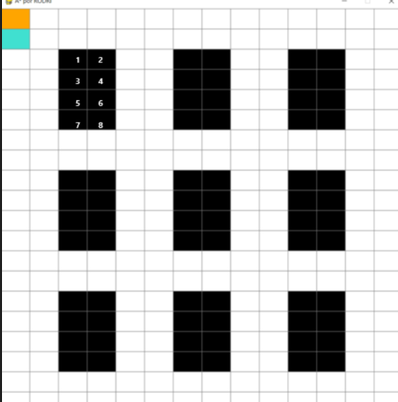

Corrección: se necesita tener más de 100 espacios en al almacen, por lo que se agrega una fila extra de almacenamiento

Corrección 2: se redujo de manera considerable la cantidad de espacios para disminuir los tiempos de cómputo sobre todo en el ejercicio 3 de algoritmo genético

Asigno números

In [5]:
def asignarNumero(matriz):
    
    #De forma muy rústica le pongo números a cada elemento del almácen.

    #ELEMENTOS DE LA IZQUIERDA
    conteo = 1
    conjuntoDe8(matriz, 2, 2, conteo) #asigno del 1 al 8
    conteo += 8
    conjuntoDe8(matriz, 6, 2, conteo) #asigno del 9 al 16
    # conteo += 8
    # conjuntoDe8(matriz, 10, 2, conteo) #asigno del 17 al 24
    # conteo += 8
    # conjuntoDe8(matriz, 14, 2, conteo)

    #ELEMENTOS DEL CENTRO
    conteo += 8
    conjuntoDe8(matriz, 2, 8, conteo) #asigno del 25 al 32
    conteo += 8
    conjuntoDe8(matriz, 6, 8, conteo) #asigno del 33 al 40
    # conteo += 8
    # conjuntoDe8(matriz, 10, 8, conteo) #asigno del 41 al 48
    # conteo += 8
    # conjuntoDe8(matriz, 14, 8, conteo)

    #ELEMENTOS DE LA DERECHA
    conteo += 8
    conjuntoDe8(matriz, 2, 14, conteo) #asigno del 49 al 56
    conteo += 8
    conjuntoDe8(matriz, 6, 14, conteo) #asigno del 54 al 64
    # conteo += 8
    # conjuntoDe8(matriz, 10, 14, conteo) #asigno del 65 al 72
    # conteo += 8
    # conjuntoDe8(matriz, 14, 14, conteo)

    #AGREGO UNA MÁS A LA DERECHA PARA TENER MÁS DE 100 POSICIONES
    # conteo += 8
    # conjuntoDe8(matriz, 2, 20, conteo) 
    # conteo += 8
    # conjuntoDe8(matriz, 6, 20, conteo)
    # conteo += 8
    # conjuntoDe8(matriz, 10, 20, conteo) 
    # conteo += 8
    # conjuntoDe8(matriz, 14, 20, conteo)


def conjuntoDe8(matriz, xi, yi, conteo): #xi e yi determinan la posición del nodo más arriba a la izquierda del conjunto de 8
    for j in range(yi,yi+4):
        for i in range(xi, xi+2):
            matriz[i][j].numeroAlmacen = conteo
            matriz[i][j].numeroProducto = conteo #inicialmente cada producto compartirá el mismo número de almacen, esto cambiará en el punto 3 de algoritmo genético
            matriz[i][j].hacer_obstaculo()
            conteo += 1


### Algoritmo A*


In [6]:
#F(n) = C(n)+H(n) el valor para cierto nodo es la suma entre el costo y le heurística.
def algoritmoAestrella(matriz, nodo_inicial, nodo_objetivo):

    #Conociendo el nodo final, calculo la heurística para cada nodo de la matriz
    for fila in matriz:
        for nodo in fila:
            nodo.calcular_heuristica(nodo_objetivo)

            #De paso reinicio el valor g y f de cada nodo (para poder volver a correr el algorimo en un mismo tablero)
            nodo.reiniciar_g_f_padre()

    #Declaro los valores de costo de camino y puntaución f para el nodo inicial
    nodo_inicial.g = 0
    nodo_inicial.actualizar_f()

    #Agrego inicio a la cola de análisis
    cola = [nodo_inicial]

    flag = True
    while flag:

        #Selecciono el nodo con menor f en la cola
        f_min = float('inf')

        if len(cola)==0: #Esto es para evitar que falle el programa cuando no hay nada en la lista cola
            print('No hay solucion')
            return False

        for nodo in cola:
            if nodo.f < f_min:
                f_min = nodo.f
                seleccion = nodo

        cola.remove(seleccion)  #Elimino de la cola al nodo que se analizará a continuación
    
        #A cada vecino le actualizaré el valor g SOLO SI EL VALOR g NUEVO ES MENOS AL QUE YA TENÍAN 
        #De paso si, el g cambia, le tengo que cambiar el padre al vecino. Esto lo hago para que una casilla, que ya fue analizada, pueda tener un nuevo camino pero más corto.
        for vecino in seleccion.vecinos:

            if vecino == nodo_objetivo:
                vecino.padre = seleccion
                
                #Meto las casillas que conforman el camino en una lista
                guardarCamino(matriz, vecino) 
                
                #Reinicio el sistema de padres para poder luego volver a aplicar A*
                for fila in matriz:
                    for nodo in fila:
                        nodo.padre = None  
                
                #Vuelvo los nodos importantes a su estado inicial
                nodo_objetivo.hacer_objetivo_almacen()
                INICIO.hacer_inicio()

                return False
                

            elif seleccion.g+1 < vecino.g:
                vecino.g = seleccion.g+1
                vecino.padre = seleccion
        
            #Actualizo los valores f de cada vecino
            f_viejo = vecino.f #guardo el valor f antes de cambiarlo para analizarlo más tarde
            vecino.actualizar_f()

            #Pongo al vecino en cola de análisis sólo si su nuevo valor f es menor al que tenía, y si no es un obstaculo
            if vecino.f < f_viejo and not vecino.es_obstaculo() and not vecino.es_objetivo_almacen():
                #Lo pinto de verde para indicar que está en cola de análisis
                vecino.hacer_abierta()
                cola.append(vecino)
        
        
        #Finalmente, pinto el nodo analizado de rojo para indicar que ya ha sido analizado
        if not seleccion.es_inicio():    #Para que no se pinte de rojo la casilla inicial
            seleccion.hacer_cerrada()
        

### Función main

Tengo que hacer los siguientes pasos:

- Recorro la matriz de nodo hasta encontrar un espacio de almacén
- Para ese espacio de almacén, analizo sus vecinos para determinar cuaáles son sus espacios libres adyacentes (casilla de color blanco). Las casillas en las esquinas tendrán 2, las otras tendrán solo 1. Para simplificar el problema, considero que el robot sólo puede acceder a los espacios de almacen desde los costados. Por lo tanto en las esquinas, el robot no puede acceder al producto desde una casilla que no sea la lateral
- Coloco esas casillas libres en cola de análisis.
- En un diccionario tengo que almacenar la coordenada x,y 
- Por cada casilla en cola de análisis, tengo que hacer A* con el resto de espacios en el almacén. Los resultados también tengo que guardarlos en el diccionario.

El diccionario sería así: DiccionarioDistancias = { [x1,y1]: {almacen1 = dist1, almacen2 = dist2, ...} , [x2,y2]: {almacen1 = dist1, ...} ...}
Dentro del diccionario, cada key es una de esas casillas vacías. El valor de cada key es otro diccionario que tiene como key la posición de almacén al que va a ir y como valor, el costo de camino.



In [7]:
def main():
    matriz = crearMatrizNodos()
    asignarNumero(matriz)

    global INICIO
    global FINAL
    global CAMINO
    global DICCIONARIO_DISTANCIAS

    lista_nodos_analizar = []
    
    #Primero genero todos los vecinos de la matriz
    for fila in matriz:
        for nodo in fila:
            nodo.actualizar_vecinos(matriz)

            #si el nodo es un espacio de almacén, lo guardo en cola de análisis
            if nodo.esEspacioEnAlmacen():
                lista_nodos_analizar.append(nodo)

    #Verifico que haya la cantidad correcta de nodos a analizar. Deberían haber 128 (ya que hay 128 espacios de almacén y cada uno se accede por una ubicación específica)
    print("Los nodos a analizar son", len(lista_nodos_analizar))

    #Una vez creada la lista de nodos a analizar, para cada uno de estos nodos, tengo que calcular la distancia a cada espacio de almacén usando A*

    for nodo_almacen in lista_nodos_analizar:

        #Creo la key en el diccionario y le establezco el formato.
        DICCIONARIO_DISTANCIAS.update({nodo_almacen.numeroAlmacen: {1:0}})

        #El inicio será la casilla al costado del espacio_almacen
        #El primer vecino siempre será el que tiene al costado, por donde se accede al almacén
        INICIO = nodo_almacen.vecinos[0]


        print("\nNodo analizado: ({},{}) - N° Almacén {}\n".format(INICIO.columna_casilla, INICIO.fila_casilla, nodo_almacen.numeroAlmacen))

        for fila in matriz:
            for nodo in fila:

                if nodo.esEspacioEnAlmacen(): #si el nodo es un espacio de almacén, tengo que calcular la distancia hasta él partiendo del INICIO.

                    FINAL = nodo
                    FINAL.hacer_objetivo_almacen()

                    #Tengo que volver a calcular los vecinos ya que ahora el nodo FINAL ya no es más un obstáculo, sino un objetivo
                    for fila in matriz:
                        for punto in fila:
                            punto.actualizar_vecinos(matriz)
                    
                    algoritmoAestrella(matriz, INICIO, FINAL)

                    print("({},{}) - N° Almacen: {} - Dist: {}".format(FINAL.columna_casilla, FINAL.fila_casilla, FINAL.numeroAlmacen, len(CAMINO)))

                    #key = (nodo_analizado.columna_casilla, nodo_analizado.fila_casilla)

                    DICCIONARIO_DISTANCIAS[nodo_almacen.numeroAlmacen][nodo.numeroAlmacen] = len(CAMINO)

                    #Reinicio variables
                    FINAL.hacer_obstaculo()
                    CAMINO = [] #limpio el camino para la proxima iteración

        print("---------------------------------------------------------------")


# EJECUCION

In [8]:
main()



Los nodos a analizar son 48

Nodo analizado: (1,2) - N° Almacén 1

(2,2) - N° Almacen: 1 - Dist: 0
(2,3) - N° Almacen: 3 - Dist: 1
(2,4) - N° Almacen: 5 - Dist: 2
(2,5) - N° Almacen: 7 - Dist: 3
(2,8) - N° Almacen: 17 - Dist: 6
(2,9) - N° Almacen: 19 - Dist: 7
(2,10) - N° Almacen: 21 - Dist: 8
(2,11) - N° Almacen: 23 - Dist: 9
(2,14) - N° Almacen: 33 - Dist: 12
(2,15) - N° Almacen: 35 - Dist: 13
(2,16) - N° Almacen: 37 - Dist: 14
(2,17) - N° Almacen: 39 - Dist: 15
(3,2) - N° Almacen: 2 - Dist: 5
(3,3) - N° Almacen: 4 - Dist: 6
(3,4) - N° Almacen: 6 - Dist: 7
(3,5) - N° Almacen: 8 - Dist: 8
(3,8) - N° Almacen: 18 - Dist: 9
(3,9) - N° Almacen: 20 - Dist: 10
(3,10) - N° Almacen: 22 - Dist: 11
(3,11) - N° Almacen: 24 - Dist: 12
(3,14) - N° Almacen: 34 - Dist: 15
(3,15) - N° Almacen: 36 - Dist: 16
(3,16) - N° Almacen: 38 - Dist: 17
(3,17) - N° Almacen: 40 - Dist: 18
(6,2) - N° Almacen: 9 - Dist: 6
(6,3) - N° Almacen: 11 - Dist: 7
(6,4) - N° Almacen: 13 - Dist: 8
(6,5) - N° Almacen: 15 - Dis

In [9]:
DICCIONARIO_DISTANCIAS

{1: {1: 0,
  3: 1,
  5: 2,
  7: 3,
  17: 6,
  19: 7,
  21: 8,
  23: 9,
  33: 12,
  35: 13,
  37: 14,
  39: 15,
  2: 5,
  4: 6,
  6: 7,
  8: 8,
  18: 9,
  20: 10,
  22: 11,
  24: 12,
  34: 15,
  36: 16,
  38: 17,
  40: 18,
  9: 6,
  11: 7,
  13: 8,
  15: 9,
  25: 10,
  27: 11,
  29: 12,
  31: 13,
  41: 16,
  43: 17,
  45: 18,
  47: 19,
  10: 9,
  12: 10,
  14: 11,
  16: 12,
  26: 13,
  28: 14,
  30: 15,
  32: 16,
  42: 19,
  44: 20,
  46: 21,
  48: 22},
 3: {1: 1,
  3: 0,
  5: 1,
  7: 2,
  17: 5,
  19: 6,
  21: 7,
  23: 8,
  33: 11,
  35: 12,
  37: 13,
  39: 14,
  2: 6,
  4: 7,
  6: 8,
  8: 7,
  18: 8,
  20: 9,
  22: 10,
  24: 11,
  34: 14,
  36: 15,
  38: 16,
  40: 17,
  9: 7,
  11: 8,
  13: 9,
  15: 8,
  25: 9,
  27: 10,
  29: 11,
  31: 12,
  41: 15,
  43: 16,
  45: 17,
  47: 18,
  10: 10,
  12: 11,
  14: 12,
  16: 11,
  26: 12,
  28: 13,
  30: 14,
  32: 15,
  42: 18,
  44: 19,
  46: 20,
  48: 21},
 5: {1: 2,
  3: 1,
  5: 0,
  7: 1,
  17: 4,
  19: 5,
  21: 6,
  23: 7,
  33: 10,
  35: 

In [10]:
DICCIONARIO_DISTANCIAS[2][1]

5

Como para cada uno de los 128 elementos, está relacionado con todos los otros, hay 128*128 elementos en el diccionario hay 16384 entradas. Se puede reducir a la mitad si consideramos que ir del espacio 1 al 2, es lo mismo que ir del 2 al 1.

Lo mismo con cualquier otra permutación. Se puede eliminar casi la mitad de entradas usando esto.

Sin embargo, para simplificar, usaré el diccionario completo.

## Guardar diccionario

Para guardarlo, lo más facil es crear un dataframe partiendo del diccionario.

In [11]:
import pandas as pd

df = pd.DataFrame().from_dict(DICCIONARIO_DISTANCIAS)

df

,1,3,5,7,17,19,21,23,33,35,...,14,16,26,28,30,32,42,44,46,48
1,0,1,2,3,6,7,8,9,12,13,...,11,12,13,14,15,16,19,20,21,22
3,1,0,1,2,5,6,7,8,11,12,...,12,11,12,13,14,15,18,19,20,21
5,2,1,0,1,4,5,6,7,10,11,...,11,10,11,12,13,14,17,18,19,20
7,3,2,1,0,3,4,5,6,9,10,...,10,9,10,11,12,13,16,17,18,19
17,6,5,4,3,0,1,2,3,6,7,...,11,10,9,10,11,12,13,14,15,16
19,7,6,5,4,1,0,1,2,5,6,...,12,11,10,11,12,11,12,13,14,15
21,8,7,6,5,2,1,0,1,4,5,...,13,12,11,12,11,10,11,12,13,14
23,9,8,7,6,3,2,1,0,3,4,...,14,13,12,11,10,9,10,11,12,13
33,12,11,10,9,6,5,4,3,0,1,...,17,16,13,12,11,10,9,10,11,12
35,13,12,11,10,7,6,5,4,1,0,...,18,17,14,13,12,11,10,11,12,11


In [12]:
df[1][3]

1

Ahora puedo guardarlo fácilmente en formato csv

In [13]:
df.to_csv('dfDistancias.csv')

## Prueba cargado de diccionario

De esta forma no hace falta calcular la distancia entre las casillas cada vez que se ejecuta el programa

In [14]:
dfPrueba = pd.read_csv('dfDistancias.csv', index_col='Unnamed: 0')

dfPrueba

,1,3,5,7,17,19,21,23,33,35,...,14,16,26,28,30,32,42,44,46,48
1,0,1,2,3,6,7,8,9,12,13,...,11,12,13,14,15,16,19,20,21,22
3,1,0,1,2,5,6,7,8,11,12,...,12,11,12,13,14,15,18,19,20,21
5,2,1,0,1,4,5,6,7,10,11,...,11,10,11,12,13,14,17,18,19,20
7,3,2,1,0,3,4,5,6,9,10,...,10,9,10,11,12,13,16,17,18,19
17,6,5,4,3,0,1,2,3,6,7,...,11,10,9,10,11,12,13,14,15,16
19,7,6,5,4,1,0,1,2,5,6,...,12,11,10,11,12,11,12,13,14,15
21,8,7,6,5,2,1,0,1,4,5,...,13,12,11,12,11,10,11,12,13,14
23,9,8,7,6,3,2,1,0,3,4,...,14,13,12,11,10,9,10,11,12,13
33,12,11,10,9,6,5,4,3,0,1,...,17,16,13,12,11,10,9,10,11,12
35,13,12,11,10,7,6,5,4,1,0,...,18,17,14,13,12,11,10,11,12,11


El índice esta en formato str. Lo cambio a int reemplazandolo por una lista igual al indice

In [15]:
dfPrueba.set_axis(dfPrueba.index, axis=1, inplace=True)
dfPrueba

,1,3,5,7,17,19,21,23,33,35,...,14,16,26,28,30,32,42,44,46,48
1,0,1,2,3,6,7,8,9,12,13,...,11,12,13,14,15,16,19,20,21,22
3,1,0,1,2,5,6,7,8,11,12,...,12,11,12,13,14,15,18,19,20,21
5,2,1,0,1,4,5,6,7,10,11,...,11,10,11,12,13,14,17,18,19,20
7,3,2,1,0,3,4,5,6,9,10,...,10,9,10,11,12,13,16,17,18,19
17,6,5,4,3,0,1,2,3,6,7,...,11,10,9,10,11,12,13,14,15,16
19,7,6,5,4,1,0,1,2,5,6,...,12,11,10,11,12,11,12,13,14,15
21,8,7,6,5,2,1,0,1,4,5,...,13,12,11,12,11,10,11,12,13,14
23,9,8,7,6,3,2,1,0,3,4,...,14,13,12,11,10,9,10,11,12,13
33,12,11,10,9,6,5,4,3,0,1,...,17,16,13,12,11,10,9,10,11,12
35,13,12,11,10,7,6,5,4,1,0,...,18,17,14,13,12,11,10,11,12,11


Probamos que ande correctamente

In [16]:
dfPrueba[1][3]

1